# Example Anderson paper



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import random as rnd

X = np.array([[4.91, 2.16], [6.05, 5.54], [3.48, 1.35], [8.09, 0.18], [2.53, 3.49],
             [1.62, 2.46], [8.37, 2.29], [3.17, 6.27], [6.02, 4.51], [8.50, 4.65],
             [4.21, 5.93], [0.15, 5.99], [9.31, 3.77], [4.10, 0.45], [5.83, 2.42],
             [6.00, 0.27], [3.30, 8.93], [4.38, 7.81], [4.93, 6.64], [1.22, 1.54]])

[N, cols] = X.shape

# cutting functions along the X axis (vertical, 0) or the Y axis (horizontal, 1)
H = np.array([1,1,0,1,1,1,0,1,1,0,0,0,1,0,1,0,1,0,0,1])
print(H)

# define the permutaions 
K = np.array([10, 5, 15, 3, 7, 12, 18, 2, 4, 6, 8, 11, 13, 16, 19, 1, 9, 14, 17, 20])
print(K)

[1 1 0 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 0 1]
[10  5 15  3  7 12 18  2  4  6  8 11 13 16 19  1  9 14 17 20]


In [2]:
import pdb
import os
import pandas as pd
import numpy as np
from itertools import chain
#path = '/media/sf_Documents/Personal/Research/Statistical equivalent block-order'
#os.chdir(path)
#data =pd.read_csv(os.path.abspath('/content/drive/My Drive/Statistical equivalent block-order/Data/Anderson_paper_data.csv'), sep = ';', decimal = '.')
data_x = pd.DataFrame(X)#data.iloc[:,0:2]#
data_x.columns = ['x_1', 'x_2']
#data_y = data.iloc[:,2:4]
[rows, cols] = X.shape#data_x.shape#

In [3]:
class block():
    def __init__(self, 
                 vertices = None, 
                 elements = None, 
                 stats = None, 
                 parent = None, 
                 leftChild = None, 
                 rightChild = None,
                 prefChild = None):
        self.vertices = vertices   # array with 2 bidimensional elemntes, corresponding to the vertices of the block
                                   # vertices must be ordered starting from the left bottom vertix and finishing with the
                                   # right top vertix
                                   # the array must have two rows and two columns (bidimensional case)
        self.elements = elements   # array with the points that belong to the block. Each row contains an element and each
                                   # column is a dimension (in this case, bidimensional)
        self.stats = np.sort(stats) # array with index of blocks
        self.parent = parent       # parent of the block
        self.leftChild = leftChild
        self.rightChild = rightChild
        self.prefChild = prefChild
    
    def plot(self, color = 'C0', lw = 1, size = 12, print_num = True):
        plt.plot(self.vertices[:,0], np.ones(2)*self.vertices[0,1], color = color, lw = lw)
        plt.plot(np.ones(2)*self.vertices[1,0], self.vertices[:,1], color = color, lw = lw)
        plt.plot(self.vertices[:,0], np.ones(2)*self.vertices[1,1], color = color, lw = lw)
        plt.plot(np.ones(2)*self.vertices[0,0], self.vertices[:,1], color = color, lw = lw)
        xplot = (self.vertices[0,0]+self.vertices[1,0])/2
        yplot = (self.vertices[0,1]+self.vertices[1,1])/2
        if self.stats.size == 1 and print_num:
            plt.text(xplot, yplot, str(self.stats[0]), fontsize = size)

        
    def split(self, axis, korder):
        """
        This method split a Block and creates two child blocks, making the partirion 
        on the korder th statistic
        axis: indicates wheter it is along 
              the X axis (vertical, 0) or 
              the Y axis (horizontal, 1)
        korder: is the order statistic to make the partition
        """
        # select the dimension to sort
        Xele = self.elements[:,axis]
        # select the kth order statistic
        Xorder = np.sort(Xele)
        minStat = min(self.stats)
        korder = korder - minStat
        xstat = Xorder[korder]
        # divide the stats
        statsL = self.stats[:korder+1]
        statsR = self.stats[korder+1:]
        # create the elements and vertices of each block
        Relements = np.empty((0, 2))
        Lelements = np.empty((0, 2))
        
        # add elements to vertices and elements for each case
        if axis == 0:
            Lvertices = np.array([self.vertices[0,:], [xstat, self.vertices[1,1]]])
            Rvertices = np.array([[xstat, self.vertices[0,1]], self.vertices[1,:]])
            # now we move on the elements of the parent block and select wich ones 
            # go to the left and right child
            for l in range(self.elements.shape[0]):
                if Xele[l] < xstat:
                    Lelements = np.append(Lelements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                elif Xele[l] > xstat:
                    Relements = np.append(Relements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                else:
                    Pchild =  [self.elements[l, :]]  # choosen k-th order 
        elif axis == 1:
            Lvertices = np.array([self.vertices[0,:], [self.vertices[1,0], xstat]])
            Rvertices = np.array([[self.vertices[0,0], xstat],self.vertices[1,:]])
            # now we move on the elements of the parent block and select wich ones go to the left and right child
            for l in range(self.elements.shape[0]):
                if Xele[l] < xstat:
                    Lelements = np.append(Lelements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                elif Xele[l] > xstat:
                    Relements = np.append(Relements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                else:
                    Pchild =  [self.elements[l, :]]  # choosen k-th order 
                
        # create the childs of the block
        Rchild = block(vertices = Rvertices, 
                       elements = Relements, 
                       stats = statsR, 
                       parent = self)  
        # right side or up side (the greaters elements)
        Lchild = block(vertices = Lvertices, 
                       elements = Lelements, 
                       stats = statsL, 
                       parent = self)   
        # left side or down side (the smaller elements)
        
        # asociate the childs to the parten
        self.rightChild = Rchild
        self.leftChild = Lchild
        self.prefChild = Pchild
        # return the place where the partition was made
        return xstat

Point [array([4.38, 7.81])] was selection 1 in iteration 1
Point [array([2.53, 3.49])] was selection 2 in iteration 2
Point [array([5.83, 2.42])] was selection 3 in iteration 3
Point [array([3.48, 1.35])] was selection 4 in iteration 4
Point [array([3.17, 6.27])] was selection 5 in iteration 5
Point [array([6.  , 0.27])] was selection 6 in iteration 6
Point [array([6.05, 5.54])] was selection 7 in iteration 7
Point [array([1.62, 2.46])] was selection 8 in iteration 8
Point [array([4.1 , 0.45])] was selection 9 in iteration 9
Point [array([0.15, 5.99])] was selection 10 in iteration 10
Point [array([4.21, 5.93])] was selection 11 in iteration 11
Point [array([4.91, 2.16])] was selection 12 in iteration 12
Point [array([8.09, 0.18])] was selection 13 in iteration 13
Point [array([4.93, 6.64])] was selection 14 in iteration 14
Point [array([8.5 , 4.65])] was selection 15 in iteration 15
Point [array([1.22, 1.54])] was selection 16 in iteration 16
Point [array([3.3 , 8.93])] was selection 

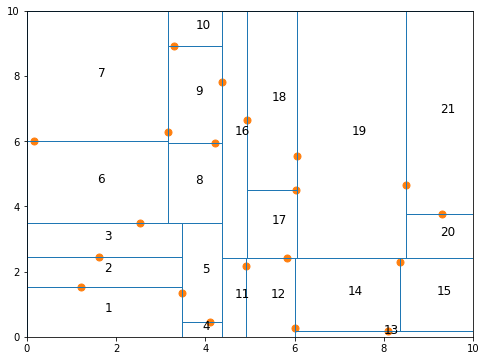

In [4]:
# create list with blocks
First_Block = block(vertices = np.array([[0,0],[10,10]]), 
                    elements = X, 
                    stats = range(1,N+2))

Blocks_List = [First_Block]

for i in range(N):
    # search the last block that has the K[i] stat
    for j in range(len(Blocks_List)):
        if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
            Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
            Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
            break

# plot
fig = plt.figure(figsize=(8,6))
plt.plot(X[:,0], X[:,1], 'o', color = 'C1', ms = 7)

plt.xlim(0,10)
plt.ylim(0,10)
block_ref = list()
for j in range(len(Blocks_List)):
    if Blocks_List[j].leftChild == None:
        Blocks_List[j].plot()
        block_ref.append(Blocks_List[j].stats)

# Defining the selection list
cont = 1
for i in range(len(Blocks_List)):
  if Blocks_List[i].prefChild != None:
    print('Point', Blocks_List[i].prefChild, 'was selection', cont, 'in iteration', i+1)
    cont += 1


# Bisection Method for a sample of size 15


Point [array([4.93, 6.64])] was selection 1 in iteration 1
Point [array([4.21, 5.93])] was selection 2 in iteration 2
Point [array([5.83, 2.42])] was selection 3 in iteration 3
Point [array([4.1 , 0.45])] was selection 4 in iteration 4
Point [array([3.17, 6.27])] was selection 5 in iteration 5
Point [array([8.09, 0.18])] was selection 6 in iteration 6
Point [array([8.5 , 4.65])] was selection 7 in iteration 7
Point [array([2.53, 3.49])] was selection 8 in iteration 8
Point [array([4.91, 2.16])] was selection 9 in iteration 9
Point [array([0.15, 5.99])] was selection 10 in iteration 10
Point [array([4.38, 7.81])] was selection 11 in iteration 11
Point [array([6.  , 0.27])] was selection 12 in iteration 12
Point [array([8.37, 2.29])] was selection 13 in iteration 13
Point [array([6.05, 5.54])] was selection 14 in iteration 14
Point [array([9.31, 3.77])] was selection 15 in iteration 15


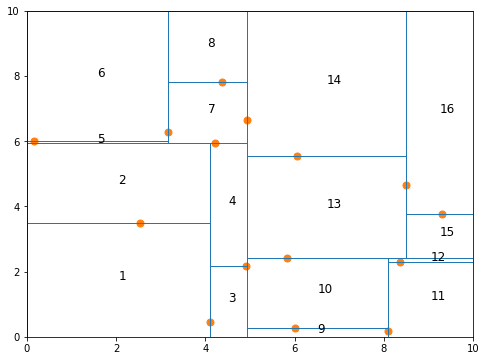

In [5]:
rnd.seed(9)
new_X = X[np.random.choice(len(X),15,replace=False)]
[N, cols] = new_X.shape

# cutting functions along the X axis (vertical, 0) or the Y axis (horizontal, 1)
H = np.array([1,0,1,1,1,0,1,0,1,0,1,1,1,0,1])

# define the permutaions 
K = np.array([8,4,12,2,6,10,14,1,3,5,7,9,11,13,15])

# create list with blocks
First_Block = block(vertices = np.array([[0,0],[10,10]]), 
                    elements = new_X, 
                    stats = range(1,N+2))

Blocks_List = [First_Block]

for i in range(N):
    # search the last block that has the K[i] stat
    for j in range(len(Blocks_List)):
        if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
            Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
            Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
            break

# plot
fig = plt.figure(figsize=(8,6))
plt.plot(new_X[:,0], new_X[:,1], 'o', color = 'C1', ms = 7)

plt.xlim(0,10)
plt.ylim(0,10)
block_ref = list()
for j in range(len(Blocks_List)):
    if Blocks_List[j].leftChild == None:
        Blocks_List[j].plot()
        block_ref.append(Blocks_List[j].stats)

# Defining the selection list
cont = 1
for i in range(len(Blocks_List)):
  if Blocks_List[i].prefChild != None:
    print('Point', Blocks_List[i].prefChild, 'was selection', cont, 'in iteration', i+1)
    cont += 1


# Results in a Uniform Bivariate Sample

Point [array([4.95221907, 2.77667883])] was selection 1 in iteration 1
Point [array([4.46623251, 6.78458577])] was selection 2 in iteration 2
Point [array([8.92583098, 1.02810362])] was selection 3 in iteration 3
Point [array([2.42810896, 5.74497297])] was selection 4 in iteration 4
Point [array([1.56935427, 8.43961656])] was selection 5 in iteration 5
Point [array([5.96451616, 8.96183677])] was selection 6 in iteration 7
Point [array([0.40556339, 8.40256387])] was selection 7 in iteration 8
Point [array([3.22889791, 7.60896291])] was selection 8 in iteration 9
Point [array([4.79854436, 9.6249796 ])] was selection 9 in iteration 11
Point [array([3.22948758, 8.42353256])] was selection 10 in iteration 12
Point [array([4.87196224, 0.01882746])] was selection 11 in iteration 14
Point [array([1.85489532, 6.60815974])] was selection 12 in iteration 15
Point [array([0.038637  , 7.79695672])] was selection 13 in iteration 16
Point [array([0.91907099, 8.54320597])] was selection 14 in iteratio

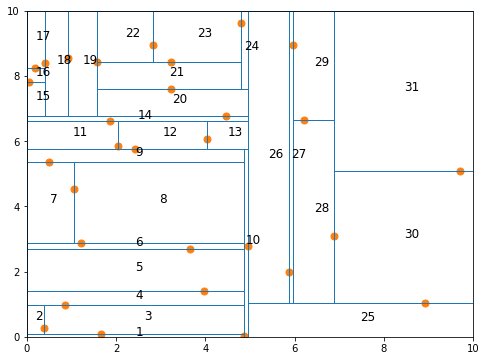

In [6]:
rnd.seed(9)
N = 30
X = np.empty((N,2))
X[:,0] = np.random.uniform(0,10,N)
X[:,1] = np.random.uniform(0,10,N)
# each cutting function is arbitrary along the X axis (vertical, 0) or the Y axis (horizontal, 1)
H = np.random.choice(cols, N)
# define the permutaions (arbitrary)
K = np.random.choice(N, N, replace=False) + 1

# create list with blocks
First_Block = block(vertices = np.array([[0,0],[10,10]]), 
                    elements = X, 
                    stats = range(1,N+2))

Blocks_List = [First_Block]

for i in range(N):
    # search the last block that has the K[i] stat
    for j in range(len(Blocks_List)):
        if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
            Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
            Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
            break

# plot
fig = plt.figure(figsize=(8,6))
plt.plot(X[:,0], X[:,1], 'o', color = 'C1', ms = 7)

plt.xlim(0,10)
plt.ylim(0,10)
block_ref = list()
for j in range(len(Blocks_List)):
    if Blocks_List[j].leftChild == None:
        Blocks_List[j].plot(print_num = True)

# Defining the selection list
cont = 1
for i in range(len(Blocks_List)):
  if Blocks_List[i].prefChild != None:
    print('Point', Blocks_List[i].prefChild, 'was selection', cont, 'in iteration', i+1)
    cont += 1



# Results in a Bivariate Elliptical Distribution

Point [array([ 2.35455581, -4.04696638])] was selection 1 in iteration 1
Point [array([-2.11933691,  1.21912047])] was selection 2 in iteration 2
Point [array([2.64769073, 1.05052996])] was selection 3 in iteration 3
Point [array([ 3.5442968, -0.3978798])] was selection 4 in iteration 4
Point [array([4.49133696, 1.39258072])] was selection 5 in iteration 5
Point [array([-3.36417836, -4.57408021])] was selection 6 in iteration 6
Point [array([0.27202601, 0.08778515])] was selection 7 in iteration 7
Point [array([ 2.75520293, -1.8544039 ])] was selection 8 in iteration 8
Point [array([7.89159615, 0.34096053])] was selection 9 in iteration 9
Point [array([-6.70916346, -2.47751628])] was selection 10 in iteration 10
Point [array([-2.33611343, -3.75889032])] was selection 11 in iteration 11
Point [array([ 3.05453644, -4.73177935])] was selection 12 in iteration 12
Point [array([ 3.11951171, -1.15768264])] was selection 13 in iteration 13
Point [array([ 0.15945454, -4.30471395])] was selecti

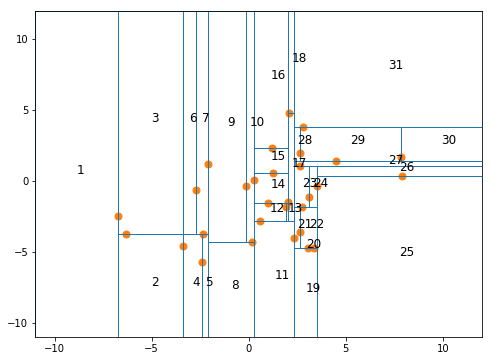

In [7]:
mean = np.array([0,0])
cov = np.array([[10,0.6],[0.6,10]])
N = 30
X = np.random.multivariate_normal(mean, cov, N)
# each cutting function is arbitrary along the X axis (vertical, 0) or the Y axis (horizontal, 1)
H = np.random.choice(cols, N)
# define the permutaions (arbitrary)
K = np.random.choice(N, N, replace=False) + 1
lim_inf = np.floor(X.min(axis=0)-X.std(axis=0))[0]
lim_max = np.ceil(X.max(axis=0)+X.std(axis=0))[0]

# create list with blocks
First_Block = block(vertices = np.array([[lim_inf,lim_inf],[lim_max,lim_max]]), 
                    elements = X, 
                    stats = range(1,N+2))

Blocks_List = [First_Block]

for i in range(N):
    # search the last block that has the K[i] stat
    for j in range(len(Blocks_List)):
        if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
            Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
            Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
            break

# plot
fig = plt.figure(figsize=(8,6))
plt.plot(X[:,0], X[:,1], 'o', color = 'C1', ms = 7)

plt.xlim(lim_inf,lim_max)
plt.ylim(lim_inf,lim_max)
block_ref = list()
for j in range(len(Blocks_List)):
    if Blocks_List[j].leftChild == None:
        Blocks_List[j].plot(print_num = True)

# Defining the selection list
cont = 1
for i in range(len(Blocks_List)):
  if Blocks_List[i].prefChild != None:
    print('Point', Blocks_List[i].prefChild, 'was selection', cont, 'in iteration', i+1)
    cont += 1



# Dense examples

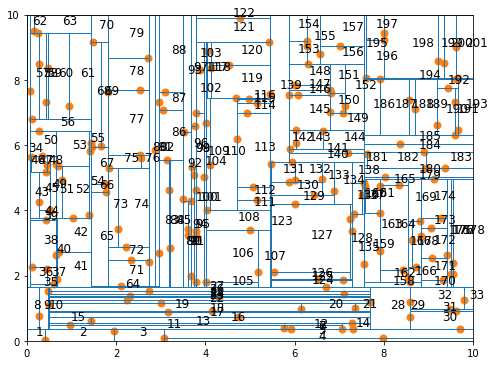

In [8]:
rnd.seed(9)
N = 200
X = np.empty((N,2))
X[:,0] = np.random.uniform(0,10,N)
X[:,1] = np.random.uniform(0,10,N)
# each cutting function is arbitrary along the X axis (vertical, 0) or the Y axis (horizontal, 1)
H = np.random.choice(cols, N)
# define the permutaions (arbitrary)
K = np.random.choice(N, N, replace=False) + 1

# create list with blocks
First_Block = block(vertices = np.array([[0,0],[10,10]]), 
                    elements = X, 
                    stats = range(1,N+2))

Blocks_List = [First_Block]

for i in range(N):
    # search the last block that has the K[i] stat
    for j in range(len(Blocks_List)):
        if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
            Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
            Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
            break

# plot
fig = plt.figure(figsize=(8,6))
plt.plot(X[:,0], X[:,1], 'o', color = 'C1', ms = 7)

plt.xlim(0,10)
plt.ylim(0,10)
block_ref = list()
for j in range(len(Blocks_List)):
    if Blocks_List[j].leftChild == None:
        Blocks_List[j].plot(print_num = True)

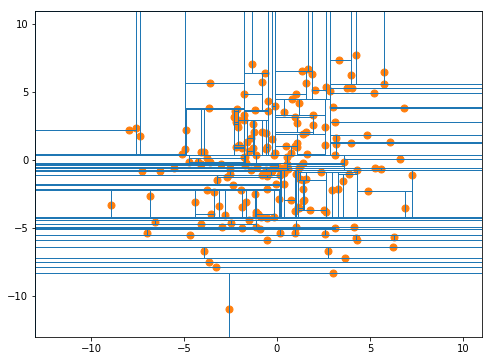

In [9]:
mean = np.array([0,0])
cov = np.array([[10,0.6],[0.6,10]])
N = 200
X = np.random.multivariate_normal(mean, cov, N)
# each cutting function is arbitrary along the X axis (vertical, 0) or the Y axis (horizontal, 1)
H = np.random.choice(cols, N)
# define the permutaions (arbitrary)
K = np.random.choice(N, N, replace=False) + 1
lim_inf = np.floor(X.min(axis=0)-X.std(axis=0))[0]
lim_max = np.ceil(X.max(axis=0)+X.std(axis=0))[0]

# create list with blocks
First_Block = block(vertices = np.array([[lim_inf,lim_inf],[lim_max,lim_max]]), 
                    elements = X, 
                    stats = range(1,N+2))

Blocks_List = [First_Block]

for i in range(N):
    # search the last block that has the K[i] stat
    for j in range(len(Blocks_List)):
        if (K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None):
            Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
            Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])            
            break

# plot
fig = plt.figure(figsize=(8,6))
plt.plot(X[:,0], X[:,1], 'o', color = 'C1', ms = 7)

plt.xlim(lim_inf,lim_max)
plt.ylim(lim_inf,lim_max)
block_ref = list()
for j in range(len(Blocks_List)):
    if Blocks_List[j].leftChild == None:
        Blocks_List[j].plot(print_num = False)